
0: 288x512 1 Hoop, 7 Players, 90.0ms
Speed: 3.0ms preprocess, 90.0ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Hoop, 7 Players, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Hoop, 8 Players, 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 5.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Ball, 1 Hoop, 7 Players, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Hoop, 7 Players, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Hoop, 7 Players, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Ball, 1 Hoop, 7 Players, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 3.0ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 Hoop, 7 Players, 16.0ms
S

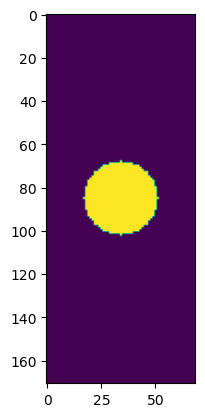

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2, os
import threading
import numpy as np
import torch
from torchvision import models, transforms
from ultralytics import YOLO
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import linear_sum_assignment
class VideoPlayer:
    def __init__(self, root):
        self.root = root
        self.root.title("Video Player - mobilenet")

        # 主框架外部框架
        outer_frame = tk.Frame(self.root)
        outer_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)
        
        # 主框架
        main_frame = tk.Frame(outer_frame)
        main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        # 左側框架
        left_frame = tk.Frame(main_frame)
        left_frame.pack(side=tk.LEFT, padx=10)

        # 影片畫布
        self.canvas = tk.Canvas(left_frame, width=800, height=480, bg="grey")
        self.canvas.pack(pady=5)

        # 控制按钮框架
        control_frame = tk.Frame(left_frame)
        control_frame.pack(pady=10)

        # 載入影片按鈕
        self.load_button = tk.Button(control_frame, text="Select Video", command=self.load_video)
        self.load_button.grid(row=0, column=0, padx=5)

        # 播放按钮
        self.play_button = tk.Button(control_frame, text="Play", command=self.play_video, state=tk.DISABLED)
        self.play_button.grid(row=0, column=1, padx=5)

        # 暂停按钮
        self.pause_button = tk.Button(control_frame, text="Pause", command=self.pause_video, state=tk.DISABLED)
        self.pause_button.grid(row=0, column=2, padx=5)

        # 停止按钮
        self.stop_button = tk.Button(control_frame, text="Stop", command=self.stop_video, state=tk.DISABLED)
        self.stop_button.grid(row=0, column=3, padx=5)

        # 右側框架
        right_frame = tk.Frame(main_frame)
        right_frame.pack(side=tk.RIGHT, padx=10)

        # 效果控制
        tk.Label(right_frame, text="Effects on").pack(pady=10)
        
        # Controls for team visibility
        self.team_a_var = tk.BooleanVar(value=True)
        self.team_b_var = tk.BooleanVar(value=True)
        self.hoop_var = tk.BooleanVar(value=True)
        self.ball_var = tk.BooleanVar(value=True)

        tk.Checkbutton(right_frame, text="Team A", variable=self.team_a_var).pack(anchor='w', pady=5)
        tk.Checkbutton(right_frame, text="Team B", variable=self.team_b_var).pack(anchor='w', pady=5)
        tk.Checkbutton(right_frame, text="Hoop", variable=self.hoop_var).pack(anchor='w', pady=5)
        tk.Checkbutton(right_frame, text="Ball", variable=self.ball_var).pack(anchor='w', pady=5)

        # 進度條
        self.progress = tk.Scale(outer_frame, from_=0, to=100, orient=tk.HORIZONTAL, length=800, label="Progress")
        self.progress.pack(side=tk.BOTTOM, fill=tk.X, padx=5, pady=5)

        self.video_path = None
        self.cap = None
        self.playing = False
        self.paused = False
        self.stop_flag = False

        # YOLOv8 model path
        current_dir = os.getcwd()
        model_path = os.path.join(current_dir, 'yolov8_trained2_0719.pt')
        self.model1 = YOLO(model_path)
        self.model1.model.names = {0: 'Ball', 1: 'Hoop', 2: 'Player'}
        
        # Load MobileNetV2 model
        self.mobilenet = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.IMAGENET1K_V1')
        self.mobilenet = torch.nn.Sequential(*list(self.mobilenet.children())[:-1])  # Remove last fully connected layer
        self.mobilenet.eval()

        # Define image preprocessing steps
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    # 讀取影片
    def load_video(self):
        self.video_path = filedialog.askopenfilename()
        if self.video_path:
            
            # 開放按鈕使用
            self.play_button.config(state=tk.NORMAL)
            self.pause_button.config(state=tk.NORMAL)
            self.stop_button.config(state=tk.NORMAL)
            
            self.cap = cv2.VideoCapture(self.video_path)
            self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
            self.progress.config(from_=0, to=100)  # Set progress(影片進度) bar range to 0-100%
            self.play_video()
        else:
            messagebox.showerror("Error", "Failed to Load Video")

    def play_video(self):
        if self.video_path and not self.playing:
            self.playing = True
            self.paused = False
            self.stop_flag = False
            threading.Thread(target=self._play).start()
        elif self.paused:
            self.paused = False

    def _play(self):
        while self.cap.isOpened() and self.playing and not self.stop_flag:
            if not self.paused:
                ret, frame = self.cap.read()
                if not ret:
                    break

                # Update progress bar as a percentage
                current_frame = int(self.cap.get(cv2.CAP_PROP_POS_FRAMES))
                percentage = int((current_frame / self.total_frames) * 100)
                self.progress.set(percentage)

                # Process frame for displaying team bounding boxes
                frame = self.process_frame(frame)

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (800, 480))
                img = Image.fromarray(frame)
                imgtk = ImageTk.PhotoImage(image=img)
                self.canvas.create_image(0, 0, anchor=tk.NW, image=imgtk)
                self.canvas.image = imgtk
                self.root.update()

                # Control playback speed
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        self.playing = False
        self.cap.release()

    # Function to extract color features (average color)
    def extract_color_features(self, image, bins=(8, 8, 8)):
        
        # Define a mask (e.g., a circular mask centered in the image)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        center = (image.shape[1] // 2, image.shape[0] // 2)
        radius = min(image.shape[0], image.shape[1]) // 4
        cv2.circle(mask, center, radius, 255, -1)
        plt.imshow(mask)
      
        # Convert the image to HSV color-space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
    
        # Compute the color histogram
        hist = cv2.calcHist([hsv_image], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256])
        # Normalize the histogram
        hist = cv2.normalize(hist, hist).flatten()
        return hist

    def load_and_preprocess_image(self, img):
        original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(original_img, (224, 224))
        return resized_img, original_img
        
    # 保持標籤一致性
    def consistent_labels(self, prev_labels, current_labels):
    
        # Create a cost matrix for label assignment
        cost_matrix = np.zeros((len(prev_labels), len(current_labels)))
    
        for i, prev_label in enumerate(set(prev_labels)):
            for j, current_label in enumerate(set(current_labels)):
                cost_matrix[i, j] = np.sum(np.array(prev_labels) == prev_label) + np.sum(np.array(current_labels) == current_label)
    
        # Find the optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
        label_mapping = {c: p for c, p in zip(col_ind, row_ind)}
        return [label_mapping.get(l, l) for l in current_labels]

    def process_image(self, img):
        results = self.model1.predict(img)[0]
        
        features_list = []

        for result in results.boxes:
            class_id = int(result.cls[0])
            
            if class_id == 2:  # player
                x1, y1, x2, y2 = map(int, result.xyxy[0])
                cropped_img = img[y1:y2, x1:x2]
                resized_img_array,original_img_array = self.load_and_preprocess_image(cropped_img)   
                color_features = self.extract_color_features(original_img_array)  #color feature (512,)          
                features_list.append(color_features)  #(63232,)

        n = len(features_list)
        if n < 2:
            print("特徵向量數量不足，無法進行聚類。")
            labels = []
        else:
            # 儲存上一幀labels
            self.previous_labels = []
        
            linked = linkage(features_list, method='ward')
            labels = fcluster(linked, t=2, criterion='maxclust')
        
            # Initialize current_labels
            current_labels = labels.copy()
        
            # Assign labels to be consistent with previous labels
            if len(self.previous_labels) > 0:
                current_labels = self.consistent_labels(self.previous_labels, current_labels)
            
            self.previous_labels = current_labels.tolist()  # Update the previous labels for the next frame


        # 依照分隊結果分配顏色
        colors = [(255, 0, 0), (0, 0, 255)]  # Red for B隊, Blue for A隊
        color_mapping = {}
        
        for label in set(labels):
            if label != -1 and label not in color_mapping:
                color_mapping[label] = colors[len(color_mapping) % len(colors)]
    
        j = 0
        for result in results.boxes:
            x1, y1, x2, y2 = map(int, result.xyxy[0])
            class_id = int(result.cls[0])
            score = float(result.conf[0])
            
            # Hoop
            if (class_id == 1 and self.hoop_var.get()):  
                color = (0, 255, 0)  # Green box
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, f'{self.model1.model.names[class_id]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            
            # Player
            elif class_id == 2:  
                if j < len(labels):
                    label = labels[j]
                    if label == -1:
                        color = (128, 128, 128)  # Gray for unclassified players
                    else:
                        color = color_mapping[label]
                    team_label = '(A)' if color == colors[1] else '(B)'
                    j += 1

                    # Add conditions to show/hide boxes based on team selection
                    if (team_label == '(A)' and self.team_a_var.get()) or (team_label == '(B)' and self.team_b_var.get()):
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img, f'{self.model1.model.names[class_id]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                    elif not self.team_a_var.get() and not self.team_b_var.get():
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img, f'{self.model1.model.names[class_id]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
           
            # Ball
            elif (class_id == 0 and self.ball_var.get()):  
                color = (255, 255, 255)  # white box
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, f'{self.model1.model.names[class_id]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
        return img

    def process_frame(self, frame):
        # Process current frame
        frame = self.process_image(frame)
        return frame
        
    def pause_video(self):
        if self.playing:
            self.paused = True

    def stop_video(self):
        if self.playing:
            self.stop_flag = True
            self.playing = False
            self.cap.release()
            self.canvas.delete("all")
            self.progress.set(0)  # Reset progress bar

if __name__ == "__main__":
    root = tk.Tk()
    app = VideoPlayer(root)
    root.mainloop()
